In [1]:
import pandas as pd 
import numpy as np
import keras
from PIL import Image
import os
import json
import cv2
import torch

C:\Users\AznNo\AppData\Local\Temp\ipykernel_5640\1438016963.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
directory = "data/dataset_6/0"
images = []

def preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

for filename in os.listdir(directory):
    # Check if the file is an image (you might want to improve this check)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Construct the full path to the image file
        filepath = os.path.join(directory, filename)
        image = Image.open(filepath)
        print("Image:", filename)
        print("Image format:", image.format)
        print("Image size:", image.size)
        print("Image mode:", image.mode)
        image = preprocess_image(filepath, target_size=(120,80))
        images.append(image)
        break


# # Path to your JSON file
# json_file_path = "BallSimSample\data.json"
# df = pd.read_json(json_file_path)
# print(df.head())

Image: 0.jpg
Image format: JPEG
Image size: (60, 40)
Image mode: L


In [3]:
from sklearn.preprocessing import StandardScaler
def process_json(json_file, img_folder):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    length = len(data) - 1
    # print(length)
    # Extract data for each sample
    img_files = [data[str(i)]["img_file"] for i in range(length)]
    car_positions = [data[str(i)]["car_pos"] for i in range(length)]
    car_velocities = [data[str(i)]["car_vel"] for i in range(length)]
    ball_in_frames = [data[str(i)]["ball_in_frame"] for i in range(length)]
    ball_positions = data["ball_trj"]["pos"]
    ball_velocities = data["ball_trj"]["vel"]
    
    # Load and store images
    images = []
    for i, img_file in enumerate(img_files):
        img_path = os.path.join(img_folder, img_file)
        # print(img_path)
        img = cv2.imread(img_path)
        if img is not None:
            # Convert image to numpy array and normalize
            img = img.astype(np.float32) / 255.0
            images.append(img)
            # print("SUCCESS")
        else:
            print(f"Error loading image: {img_path}")
    
    # Convert images to numpy array
    images = np.array(images)
    
    # Create a dictionary with the extracted data
    sample_data = {
        'images': images,
        'car_positions': car_positions,
        'car_velocities': car_velocities,
        'ball_in_frames': ball_in_frames,
        'ball_positions': ball_positions,
        'ball_velocities': ball_velocities
    }
    
    return sample_data

def create_dataframe_from_folders(json_root_folder, img_folder):
    all_samples_data = []
    
    # Iterate over subfolders in the root JSON folder
    for i, folder in enumerate(os.listdir(json_root_folder)):
        folder_path = os.path.join(json_root_folder, folder)
        # print(folder_path)
        if os.path.isdir(folder_path):
            # Initialize an empty list to hold data for the current sample
            sample_data = process_json(os.path.join(folder_path, 'data.json'), img_folder+str(i))
            
            # Append the data for the current sample to the list of all samples
            all_samples_data.append(sample_data)
        if i == 2000:
            break
    # Create DataFrame from the list of dictionaries
    df = pd.DataFrame(all_samples_data)
    # print(df)
    # scaler = StandardScaler()
    # for column in df.columns:
    #     if df[column].dtype != object:  # Exclude non-numeric columns
    #         if isinstance(df[column].iloc[0], list):  # Check if column contains lists
    #             # Flatten lists and reshape to (-1, 1) for scaling
    #             values = np.concatenate(df[column].values).ravel().reshape(-1, 1)
    #         else:
    #             values = df[column].values.reshape(-1, 1)
            
    #         # Scale values
    #         scaled_values = scaler.fit_transform(values)
            
    #         # Assign scaled values back to DataFrame
    #         df[column] = scaled_values.flatten()
    
    return df

def normalize_value(value):
    if isinstance(value, list):
        # Normalize list elements
        return [(val - np.min(value)) / (np.max(value) - np.min(value)) for val in value]
    else:
        # Return unchanged if not a list
        return value
# Example usage:
json_root_folder = 'data/dataset_6'
img_folder = 'data/dataset_6/'
df = create_dataframe_from_folders(json_root_folder, img_folder)
df.head()

,images,car_positions,car_velocities,ball_in_frames,ball_positions,ball_velocities
0,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2.966482266153105, 3.027535346713439, 3.0876...","[[0.29231126032610155, 0.28769300499707195, 0...."
1,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[4.406167965707559, 4.457454497927218, 4.5075...","[[0.2464564468427059, 0.24076560924405016, 0.2..."
2,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[5.288511802797698, 5.4255085884006995, 5.560...","[[0.6563893731302016, 0.6450800900983077, 0.63..."
3,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[4.145333906935041, 4.174442777541345, 4.2025...","[[0.14068958460443076, 0.13584468615545922, 0...."
4,"[[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2.827627505129355, 2.7414890450588323, 2.657...","[[-0.41343995805969874, -0.4048754126102626, -..."


In [4]:

# first_image = df['images'][89]
# for i in range(len(first_image)):
#     # Convert the current image to uint8 (required by cv2.imshow())
#     current_image = (first_image[i] * 255).astype('uint8')
#     # Display the current image
#     cv2.imshow(f'Image {i+1}', current_image)
#     # Wait for a key press
#     cv2.waitKey(0)

# # Close all OpenCV windows
# cv2.destroyAllWindows()

In [5]:
from sklearn.model_selection import train_test_split

X = df[['images', 'car_positions', 'car_velocities']]
y = df[['ball_positions', 'ball_velocities']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train['images'][1].shape)
height = X_train[images][0].shape[1]
width = X_train[images][0].shape[2]




(10, 40, 60, 3)


In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, LSTM, Reshape, TimeDistributed, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2

num_images = 10
image_height = height
image_width = width
num_channels = 3
num_classes = 2

def action_model(shape=(112, 112, 3), nbout=3):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=shape, kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # model.add(Flatten())
    model.add(GlobalMaxPool2D())
    return model

# Create the convnet
convnet = action_model((image_height, image_width, num_channels))

# Define inputs
image_input = Input(shape=(num_images,) + convnet.input_shape[1:], name='image_input')
velocity_input = Input(shape=(num_images, 2), name='velocity_input')
position_input = Input(shape=(num_images, 2), name='position_input')

# Apply the convnet to a sequence of images
convnet_sequence = TimeDistributed(convnet)(image_input)

# LSTM layer for image sequences
lstm_images = LSTM(64, return_sequences=True)(convnet_sequence)
lstm_images = LSTM(32, return_sequences=True)(lstm_images)
lstm_images = LSTM(16)(lstm_images)

# LSTM layers for velocity and position sequences
lstm_velocity = LSTM(64, return_sequences=True)(velocity_input)
lstm_velocity = LSTM(32, return_sequences=True)(lstm_velocity)
lstm_velocity = LSTM(16)(lstm_velocity)

lstm_position = LSTM(64, return_sequences=True)(position_input)
lstm_position = LSTM(32, return_sequences=True)(lstm_position)
lstm_position = LSTM(16)(lstm_position)

# Concatenate features
combined = concatenate([lstm_images, lstm_velocity, lstm_position])

# Dense layers for further processing
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
dropout = Dropout(0.5)(dense1)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout)
dropout = Dropout(0.5)(dense2)

# Output layers for positions and velocities
output_positions = Dense(10 * 2, activation='linear')(dropout)
reshaped_positions = Reshape((2, 10))(output_positions)

output_velocities = Dense(10 * 2, activation='linear')(dropout)
reshaped_velocities = Reshape((2, 10))(output_velocities)

# Define model
model = Model(inputs=[image_input, position_input ,velocity_input], outputs=[reshaped_positions, reshaped_velocities])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 10, 40, 60,  0           []                               
                                 3)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 10, 128)     94144       ['image_input[0][0]']            
 ted)                                                                                             
                                                                                                  
 velocity_input (InputLayer)    [(None, 10, 2)]      0           []                               
                                                                                              

In [7]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

images_tf = tf.convert_to_tensor(X_train['images'].tolist())
car_positions_tf = tf.convert_to_tensor(X_train['car_positions'].tolist())
car_velocities_tf = tf.convert_to_tensor(X_train['car_velocities'].tolist())
ball_positions_tf = tf.convert_to_tensor(y_train['ball_positions'].tolist())
ball_velocities_tf = tf.convert_to_tensor(y_train['ball_velocities'].tolist())
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print(ball_positions_tf.shape)
history = model.fit([images_tf, car_positions_tf, car_velocities_tf], [ball_positions_tf, ball_velocities_tf], validation_split=0.25,epochs=100, batch_size=32,  verbose=1, callbacks=[early_stopping])


(80, 2, 10)
Epoch 1/100
2/2 [==============================] - 13s 2s/step - loss: 8.6335 - reshape_loss: 7.4171 - reshape_1_loss: 0.1962 - reshape_mse: 7.4171 - reshape_1_mse: 0.1962 - val_loss: 10.3410 - val_reshape_loss: 9.1418 - val_reshape_1_loss: 0.1949 - val_reshape_mse: 9.1418 - val_reshape_1_mse: 0.1949
Epoch 2/100
2/2 [==============================] - 0s 119ms/step - loss: 8.5595 - reshape_loss: 7.3688 - reshape_1_loss: 0.1911 - reshape_mse: 7.3688 - reshape_1_mse: 0.1911 - val_loss: 10.2880 - val_reshape_loss: 9.1087 - val_reshape_1_loss: 0.1947 - val_reshape_mse: 9.1087 - val_reshape_1_mse: 0.1947
Epoch 3/100
2/2 [==============================] - 0s 117ms/step - loss: 8.4849 - reshape_loss: 7.3131 - reshape_1_loss: 0.1916 - reshape_mse: 7.3131 - reshape_1_mse: 0.1916 - val_loss: 10.2290 - val_reshape_loss: 9.0681 - val_reshape_1_loss: 0.1946 - val_reshape_mse: 9.0681 - val_reshape_1_mse: 0.1946
Epoch 4/100
2/2 [==============================] - 0s 121ms/step - loss: 8.356

In [8]:
test_images_tf = tf.convert_to_tensor(X_test['images'].tolist())
test_car_positions_tf = tf.convert_to_tensor(X_test['car_positions'].tolist())
test_car_velocities_tf = tf.convert_to_tensor(X_test['car_velocities'].tolist())
test_ball_positions_tf = tf.convert_to_tensor(y_test['ball_positions'].tolist())
test_ball_velocities_tf = tf.convert_to_tensor(y_test['ball_velocities'].tolist())

output = model.evaluate([test_images_tf, test_car_positions_tf, test_car_velocities_tf], [test_ball_positions_tf, test_ball_velocities_tf], batch_size=32)

print(f"Total Loss: ", output[0])
print(f"Ball Pos Loss: ", output[1])
print(f"Ball Vel Loss: ", output[2])
print(f"Ball Pos MSE: ", output[3])
print(f"Ball Vel MSE: ", output[4])

1/1 [==============================] - 0s 35ms/step - loss: 3.8097 - reshape_loss: 2.9807 - reshape_1_loss: 0.1624 - reshape_mse: 2.9807 - reshape_1_mse: 0.1624
Total Loss:  3.809708833694458
Ball Pos Loss:  2.980672597885132
Ball Vel Loss:  0.1623775064945221
Ball Pos MSE:  2.980672597885132
Ball Vel MSE:  0.1623775064945221


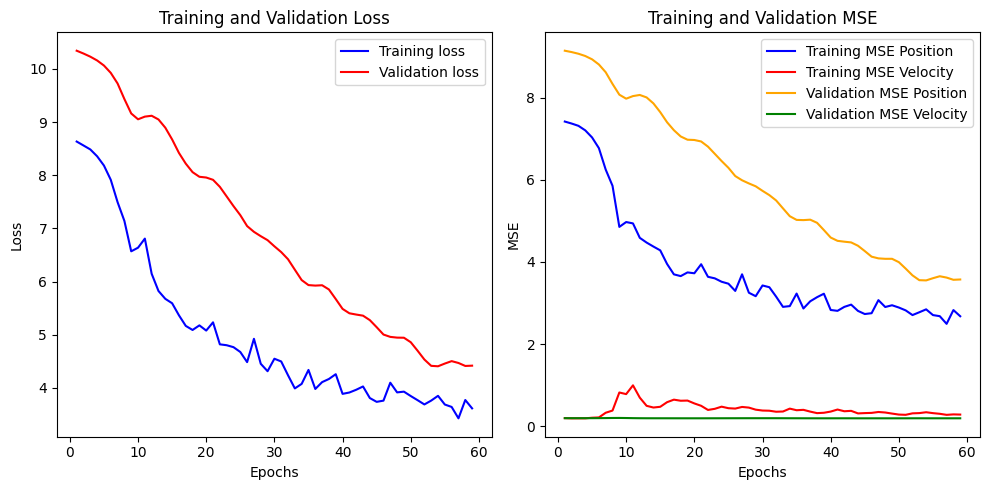

In [9]:
import matplotlib.pyplot as plt

# Get the loss and MSE values from the training history
loss = history.history['loss']
mse_pos = history.history['reshape_mse']
mse_vel = history.history['reshape_1_mse']
val_loss = history.history['val_loss']
val_mse_pos = history.history['val_reshape_mse']
val_mse_vel = history.history['val_reshape_1_mse']

# Plot the loss and MSE for each epoch
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mse_pos, 'b', label='Training MSE Position')
plt.plot(epochs, mse_vel, 'r', label='Training MSE Velocity')
plt.plot(epochs, val_mse_pos, 'orange', label='Validation MSE Position')
plt.plot(epochs, val_mse_vel, 'g', label='Validation MSE Velocity')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()
